In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from scripts.utils import load_csv, split_date, drop_columns, simplify_df, split_data_frame, impute_rolling_median, add_seasonality, apply_functions, apply_moving_average_for_roc

### Preprocessing

In [28]:
df = load_csv('../data/btc_timeseries.csv')
df = split_date(df, 'time')
df = simplify_df(df)
df = drop_columns(df, 10.0)
df = impute_rolling_median(df, 5)
df = add_seasonality(df)
df = apply_moving_average_for_roc(df, 'ema', 10, 20)

/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:153: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column].fillna(method='bfill', inplace=True)  # Backfill to address initial NaNs


In [30]:
train, val, test = split_data_frame(df, 0.7, 0.2)

In [31]:
X_train, y_train, X_val, y_val, X_test, y_test = apply_functions(train, test, val)

/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:326: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  train[features_to_standardize] = (train[features_to_standardize] - train_mean) / train_std
/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features_to_standardize] = (train[features_to_standardize] - train_mean) / train_std
/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:327: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  val

In [12]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model as tfkModel

def build_improved_LSTM_CNN(input_shape, output_units):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    # CNN Layer 1
    cnn = tfkl.Conv1D(256, 3, padding='same')(input_layer)  # Increased number of filters and adjusted kernel size
    cnn = tfkl.LeakyReLU(alpha=0.2)(cnn)
    cnn = tfkl.MaxPooling1D(pool_size=2)(cnn)  # Added pool_size

    # CNN Layer 2
    cnn = tfkl.Conv1D(128, 3, padding='same')(cnn)  # Adjusted number of filters and kernel size
    cnn = tfkl.LeakyReLU(alpha=0.2)(cnn)
    cnn = tfkl.MaxPooling1D(pool_size=2)(cnn)  # Added pool_size

    # LSTM Layer 1
    lstm = tfkl.LSTM(128, return_sequences=True)(cnn)  # Increased the number of units
    lstm = tfkl.Dropout(0.2)(lstm)  # Added dropout for regularization

    # LSTM Layer 2
    lstm = tfkl.LSTM(128)(lstm)  # Adjusted the number of units
    lstm = tfkl.Dropout(0.2)(lstm)  # Added dropout for regularization
    
    # Feature Extractor Layer
    dense = tfkl.Dense(64)(lstm)  # Adjusted the number of units
    dense = tfkl.LeakyReLU(alpha=0.2)(dense)
    dense = tfkl.Dropout(0.2)(dense)  # Added dropout for regularization

    # Output layer for regression
    output_layer = tfkl.Dense(output_units)(dense)  # No activation for regression output

    # Connect input and output through the Model class
    model = tfkModel(inputs=input_layer, outputs=output_layer, name='Improved_LSTM_CNN')

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

    return model

# Assuming input_shape is (t, number of features)
input_shape = (X_train.shape[1], X_train.shape[2])
output_units = 1  # Number of days to predict

# Build and compile the model
model = build_improved_LSTM_CNN(input_shape, output_units)
model.summary()

# Train the model
history = model.fit(
x=X_train,
y=y_train,
batch_size=32,
validation_data=(X_val, y_val),
epochs=100,
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=100, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
]
).history


Model: "Improved_LSTM_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 5, 18)]           0         
                                                                 
 conv1d (Conv1D)             (None, 5, 256)            14080     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 256)            0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 256)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 128)            98432     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 2, 128)            0         
                                                 

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def evaluate(model, X_test, y_test):

    model.evaluate(X_test, y_test, verbose=1)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    return mse, mae, mape

def plot_results(model, X_test, y_test):

    model.evaluate(X_test, y_test, verbose=1)
    y_pred = model.predict(X_test)
    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label='Actual Values')
    plt.plot(y_pred, label='Predicted Values')
    plt.title('Comparison of Actual and Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

967/967 [==============================] - 1s 1ms/step


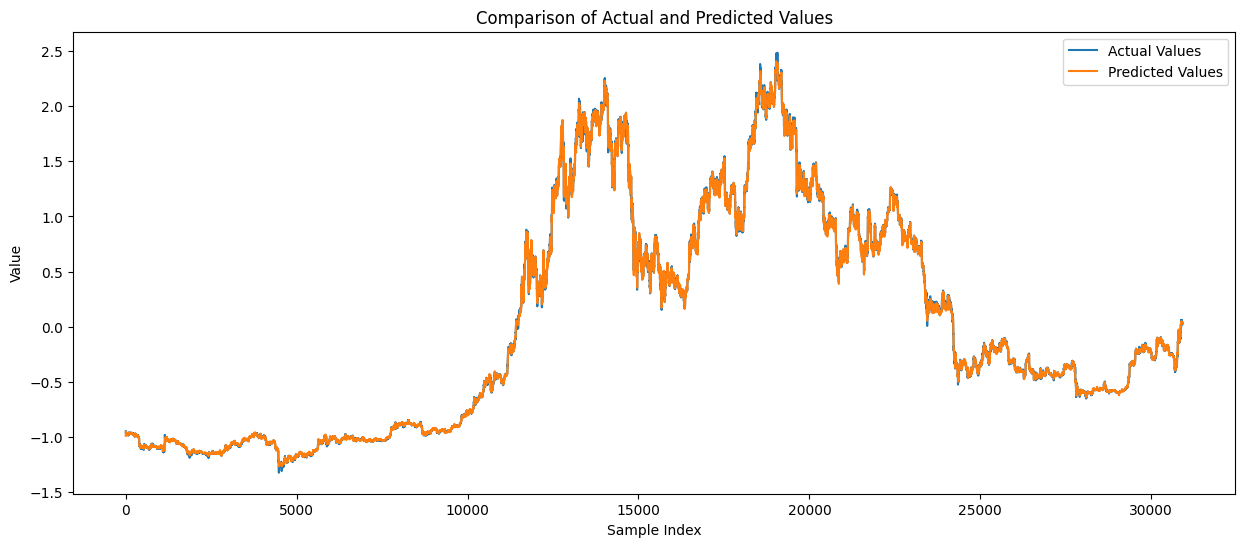

In [20]:
plot_results(model, X_train, y_train)

121/121 [==============================] - 0s 886us/step


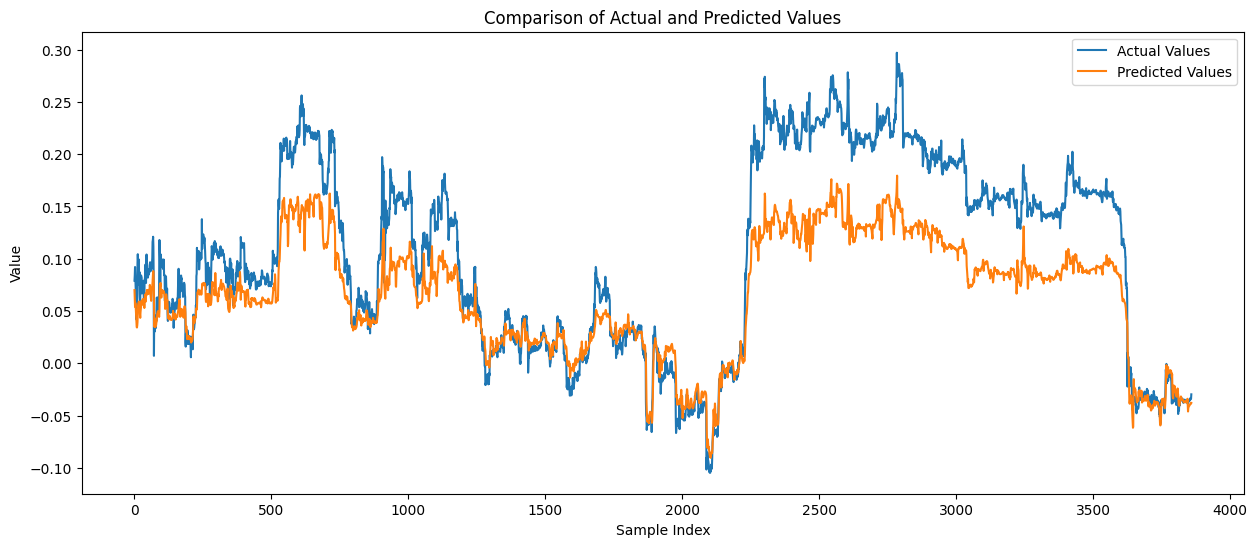

In [21]:
plot_results(model, X_val, y_val)

121/121 [==============================] - 0s 968us/step


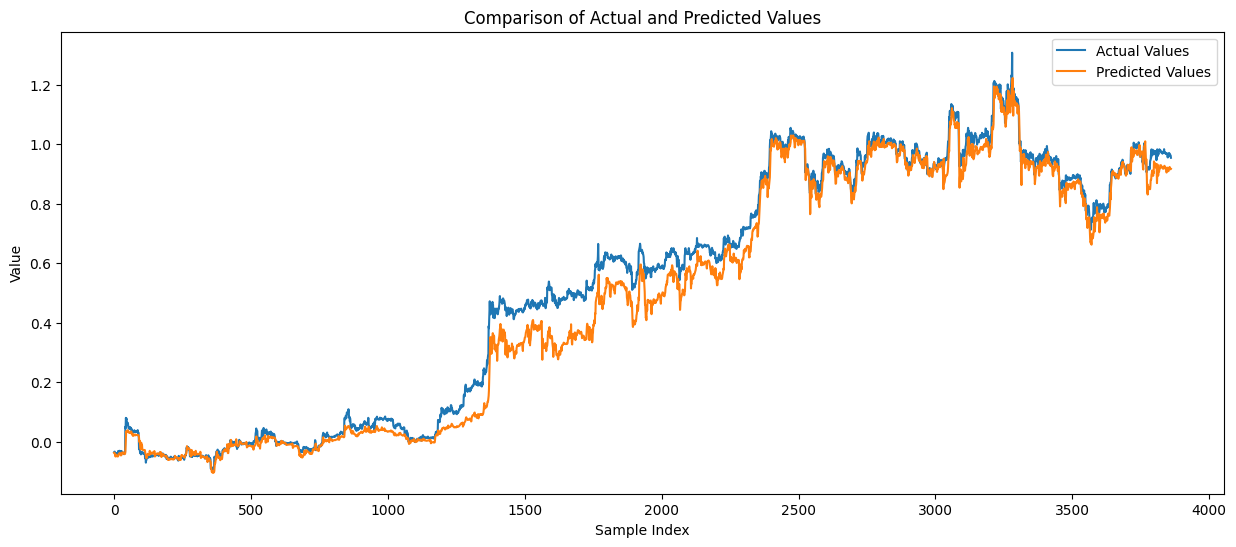

In [22]:
plot_results(model, X_test, y_test)

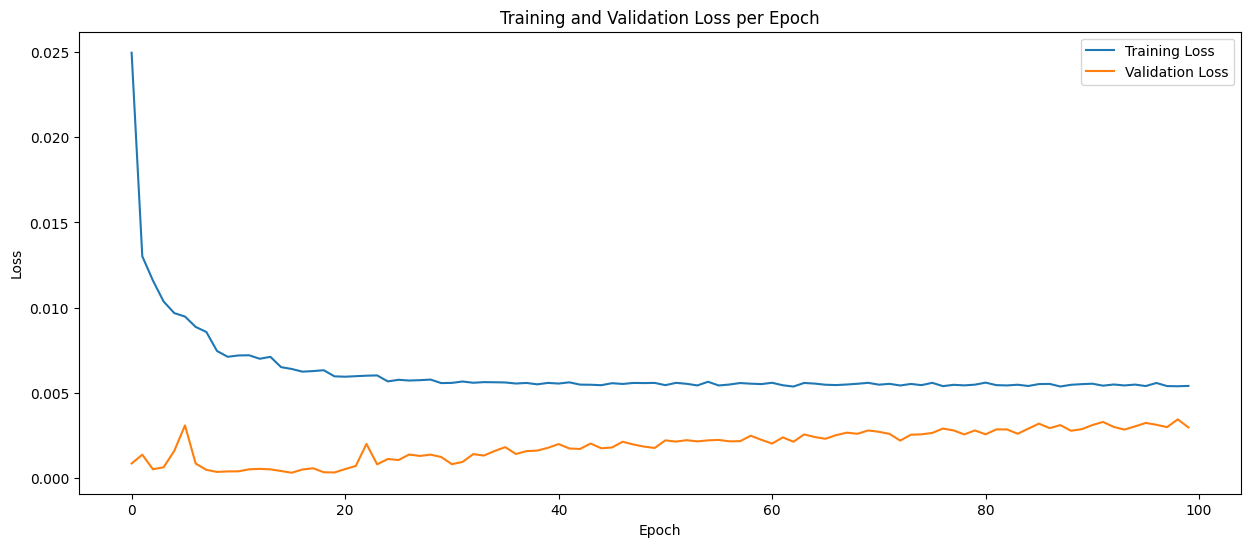

In [23]:
# Extracting loss data from the history object
train_loss = history['loss']
val_loss = history['val_loss']

# Number of epochs actually completed (may be less than 50 due to early stopping)
epochs = range(len(train_loss))

# Plotting the loss per epoch
plt.figure(figsize=(15, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
summary = []

crypto = 'BTC'
lstm_cnn = 'LSTM-CNN'
mse, mae, mape = evaluate(model, X_test, y_test)

summary.append({
    'Data': crypto,
    'Model': lstm_cnn,
    'MSE': mse,
    'MAE': mae,
    'MAPE': mape
})

# Convert list to DataFrame
lstm_cnn_df = pd.DataFrame(summary)
lstm_cnn_df

121/121 [==============================] - 0s 1ms/step


,Data,Model,MSE,MAE,MAPE
0,BTC,LSTM-CNN,0.003839,0.044432,0.475886
